In [1]:
# # !conda install -c conda-forge netcdftime
# !pip install json
# print(json.__version__)

# Introducción análisis de complementariedad eólica

Este código permite realizar estimaciones de **correlaciones del viento y precipitaciones en relación a ENSO**. Esto se logra a través del cálculo de correlaciones de Pearson y Spearman en cada píxel del mapa de los datos de precipitación y viento, con la serie temporal del índice ONI. 

En este contexto las correlaciones **positivas indican un comportamiento directo entre las series que se correlacionan**. Es decir, que si por ejemplo se dan anomalías cálidas en la SST del Pacifico Tropical y anomalías positivas en los vientos simultáneamente y así de manera regular a lo largo de las series, estaríamos hablando de un **comportamiento pre-complementario**.

Esto obedece a que las **anomalías cálidas sostenidas en el tiempo de la SST** del Pacifico indicarían la potencial presencia de un evento El Niño, el cual típicamente conlleva a la **reducción en la precipitación** en Colombia y por ende a la reducción del potencial de generación de energía hidráulica. 

Si estas **correlaciones positivas** se presentan geográficamente en zonas de alto potencial eólico, se podría pensar en **complementariedad interanual en ENSO** y no solamente de correlaciones positivas. 

Si durante los eventos **El Niño se fortalece el régimen eólico**, esto podría desencadenar un mayor interés en suplir este déficit hidroeléctrico con energía eólica.

# Procesamiento de archivos Netcdf usando Pandas y Numpy

En este código veremos como procesar archivos netcdf climáticos usando Pandas y Numpy

# ONI index

El Índice Oceánico Niño (ONI) es el principal **índice utilizado por la NOAA** para rastrear la **parte oceánica del ENSO**, el patrón climático de El Niño-Oscilación del Sur.

El ONI es el **promedio móvil de 3 meses de las anomalías de temperatura**, es decir, la diferencia con respecto a la media, en las aguas superficiales del Pacífico tropical este-central, en la zona conocida como la región Niño-3.4.

Valores del índice **iguales o superiores a +0.5 indican la presencia de El Niño si se sostienen durante 5 meses consecutivos o más**. 

Valores del índice **iguales o inferiores a -0.5 indican la presencia de La Niña si se sostienen durante 5 meses consecutivos o más .**

* Fuente: https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
* Fuente: https://earthobservatory.nasa.gov/features/ElNino
* Fuente: https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-ni%C3%B1o-index

# ¿Como se define un Niño?

A la hora de decidir si el Pacífico se encuentra en estado de El Niño, los climatólogos de la NOAA examinan las temperaturas de la superficie del mar en el centro-este del Pacífico tropical, lo que se conoce como la región del **Niño 3.4 (entre 120° y 170° Oeste)**. Se declara El Niño cuando la temperatura media se mantiene más de **0,5 grados centígrados por encima de la media a largo plazo durante cinco meses consecutivos.**

Fuente: https://earthobservatory.nasa.gov/features/ElNino

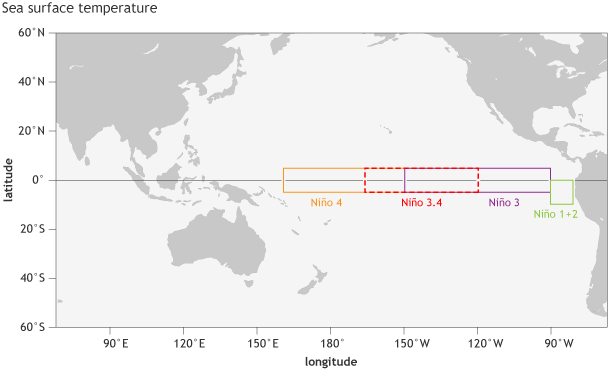

#  Datos

## Reanalysis ERA5

* ERA5 combina grandes cantidades de observaciones históricas en estimaciones globales utilizando sistemas avanzados de **modelación  y asimilación de datos**

## Cross-Calibrated Multi-Platform wind vector analysis (CCMP)

CCMP es un conjunto de datos en grilla, de alta resolución espacial y temporal, global, de vectores de viento en superficie que abarca desde 1987 hasta la actualidad. Los datos de entrada son una combinación de **datos satelitales** intercalados procedentes de numerosos radiómetros y dispersómetros y de datos in situ procedentes de boyas ancladas.

## Resolución y periodo de los datos

* Resolución ERA5 viento: espacial 0.125°; temporal: mensual; **1987-01 -- 2018-07**
* Resolución CCMP viento: espacial 0.25° ; temporal: mensual; **1987-07 -- 2017-12**
* Resolución ERA5 precip: espacial 0.125°; temporal: mensual; **1979-01 -- 2020-07**

## Periodo de comparación y cálculo de correlaciones entre series y ONI

**1987-07 a 2017-12**



## Descarga de datos para este Notebook

https://drive.google.com/drive/u/0/folders/1JDVRmAJ9mGKrnkJE1Ubn8Apuoj3B_8_t


# Importación de librerias

Lectura de librerias y una breve descripción de su utilidad en este código (ver comentarios delante de cada libreria importada)

In [2]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
# """
# Created on Tue Mar 13 10:04:34 2018
# @author: Jorge Echeverri
# """

from datetime import date, timedelta     #  suma o resta dias a una fecha
from collections import OrderedDict      #  crea diccionarios ordenados
import json                              #  leer archivos formato json y crearlos
from netCDF4 import Dataset              #  Leer archivos NetCDF
import datetime                          #  Trabajar con fechas
import matplotlib.pyplot as plt          #  crear figuras
import numpy as np                       #  operaciones artitméticas, creación de arreglos etc
from mpl_toolkits.basemap import Basemap #  Crear mapas
import matplotlib.cm as cm               #  se usa para crear la barra de colores en la función center_white_anom2
import scipy.stats as scp                #  calcula estadísticos como correlaciones entre otros
import pandas as pd                      #  perimite crear y trabajar con series y dataframes
import matplotlib.colors as colors       #  se usa para las barras de color en MidpointNormalize y center_white_anom2

# se definen parametros de formato de texto
plt.close('all')
csfont = {'fontname':'serif', 'size':17,'weight' : 600}
sfont = {'fontname':'serif', 'size':10,'weight' : 600}
csfont2 = {'fontname':'serif', 'size':13,'weight' : 600}
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Rutas de archivos
Se definen las rutas de los archivos de entrada y salida del código

In [4]:
ruta_netcdfs    =  "/Users/jaech/Mi_unidad/CURSOS/ANALISIS_DE_DATOS/MODULO_3/Datos/complementariedad/netcdfs/"   # Directorio carpeta de archivos de viento y precipitación 
ruta_shapes     =  "/Users/jaech/Mi_unidad/CURSOS/ANALISIS_DE_DATOS/MODULO_3/Datos/complementariedad/shapes/"    # Directorio carpeta de shapes de límites maritimos y departamentos de Colombia
ruta_indices    =  "/Users/jaech/Mi_unidad/CURSOS/ANALISIS_DE_DATOS/MODULO_3/Datos/complementariedad/indices/"   # Directorio de indices macroclimáticos en un archivo de formato json
ruta_figuras    =  "/Users/jaech/Mi_unidad/CURSOS/ANALISIS_DE_DATOS/MODULO_3/Datos/complementariedad/figuras/"   # Directorio donde se almacenan las figuras generadas en este código

# Funciones

## Lectura de archivos formato json

"read_json_to_pd", lee los archivos json y los convierte en series de pandas

In [5]:
# "lee json files"
def read_json_to_pd(path):
    #load json
    data = json.load(open(path,'r')) # carga el archivo json asignadolo a la variable data, el tipo de archivo de data es <class 'dict'>
    name   = data.keys()             # define un diccionario de claves de tipo <class 'dict_keys'>
    #json to serie
    Dict3 = {}
    for ii in name:
        Dict3[ii]=pd.read_json(data[ii], typ='series', orient='split') # Se crea un diccionario de indices macróclimaticos, donde cada key es un indice diferente el tipo es <class 'dict'>        
    return Dict3

## Cálculo de anomalias

"ANOMALIAS_DATAFRAME", crea series de anomalías y anomalías estandarizadas de la serie de ingreso. Las anomalías se calculan restandole la media de la serie a cada dato y las anomalías estandarizadas se calculan dividiendo las anomalias por la desviación estandar de la serie

In [6]:
# "estandariza dataframe reshepeados provenientes de netcdf"
def ANOMALIAS_DATAFRAME(df_VAR): # df_VAR es un dataframe de los datos de vientos o precipitación
    ANOMA = df_VAR * np.nan # crea un dataframe de iguales dimensiones que df_VAR pero lleno de NaNs
    STDAR = df_VAR * np.nan # crea un dataframe de iguales dimensiones que df_VAR pero lleno de NaNs
    for i in np.arange(1,13): # itera en los 12 meses del año (llega hasta i = 12, no toma el 13)
        mes = df_VAR.loc[df_VAR.index.month==i] # df.loc es una función de pandas que ubica los datos segun el criterio. En este caso el criterio es los datos del iésimo mes.  Ejemplo si el i = 1 (enero), entonces la variable 'mes' será un dataframe que contenga todos los eneros de todos los años en el mapa
        media = mes.mean() # Tipo de dato pandas Series. Es el Promedio del mes i, una serie de pandas y la longitud de la serie es igual al numero de pixeles en el mapa
        std = mes.std()    # Tipo de dato pandas Series. Es la Desviación estandar del mes i, es una serie de pandas y la longitud de la serie es igual al numero de pixeles en el mapa
        anoma = mes - media # Tipo de dato pandas DataFrame.  anoma es un dataframe que contiene todos los eneros, pero cada dato de cada hora (si son horarios los datos) se le ha restado la media de la serie de los eneros y asi sucesivamente febreros, marzos con cada iteración
        ANOMA[ANOMA.index.month==i] = anoma # Se sobreescriben los NaNs en el dataframe creado previamente 'ANOMA'. En este se ponen todos los eneros, pero en terminos de sus anomalias y asi sucesivamente en cada iteración se van llenando los meses del año, las veces que esten en el Df por ejemplo desde 1987 hasta la actualidad, hay muchos eneros que se ponen
        STDAR[STDAR.index.month==i] = anoma/std # De igual manera que con ANOMA, Se sobreescriben los NaNs en el dataframe creado previamente 'STDAR'. Pero esta vez con anomalias estandarizadas
    return ANOMA, STDAR

## Clase y función para centrar barra de color

MidpointNormalize es una Clase que define el punto medio de la barra de colores

center_white_anom2 es una función que define una barra de colores de anomalias centrada en el color blanco (valor cero), la barra toma valores negativos y positivos


In [7]:
# MidpointNormalize posiciona el cero en la barra de colores
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# center_white_anom2 define una barra de colores para anomalias o correlacones que va de menos a mas centrada en el cero
def center_white_anom2(cmap, num, bounds, limite):
    import matplotlib as mtp
    barcmap = mtp.cm.get_cmap(cmap, num)
    barcmap.set_bad(color='gray', alpha=0.5)
    bar_vals = barcmap(np.arange(num))
    pos = np.arange(num)
    centro = pos[(bounds  >=  -limite) & (bounds  <=  limite)]
    for i in centro:
        bar_vals[i] = [1, 1, 1, 1]
    newcmap = mtp.colors.LinearSegmentedColormap.from_list("new" + cmap, bar_vals)
    return newcmap


### Magnitud de la velocidad del viento

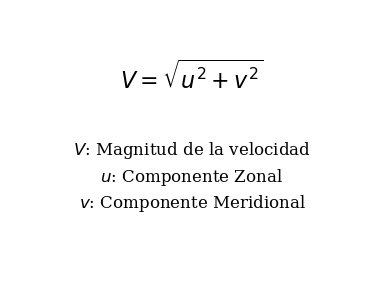

In [54]:
# Crear una figura vacía con márgenes ajustados
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
ax.text(0.5, 0.7, r'$V = \sqrt{u^2 + v^2}$', fontsize=16, ha='center')
ax.text(0.5, 0.35, r'$u$: Componente Zonal', fontsize=12, ha='center')
ax.text(0.5, 0.25, r'$v$: Componente Meridional', fontsize=12, ha='center')
ax.text(0.5, 0.45, r'$V$: Magnitud de la velocidad', fontsize=12, ha='center')
ax.axis('off')
plt.show()

# Lectura de datos

En los primeros tres bloques de código se leen los archivos NetCDF que contienen los datos climáticos de viento y precipitación. Se definen las variables con el nombre que contiene la metadata de cada archivo. Es importante imprimir (print (vientos.variables)) las variables del NetCDF para poderlas definir llamándolas con su nombre específico.

En el cuarto bloque de código se lee el archivo de indices climáticos. Especificamente para este código se hace uso del indice ONI que permite realizar análisis con ENSO.

## Lectura de datos viento Reanalysis ERA5

In [9]:
vientosE=Dataset(ruta_netcdfs+ "ERA5_WIND_COL_1987_2018_monthly.nc",'r') # Dataset lee el archivo NetCDF y se lo asigna a la variable gistem que tiene tipo netCDF4._netCDF4.Dataset
print (vientosE.variables)
lat_E2         = vientosE.variables['latitude'][:]                       # Extrae las latitudes y las asigna a la variable Lat_E2. El tipo de archivo es <class 'numpy.ndarray'>  con shape = (177,)
lon_E2         = vientosE.variables['longitude'][:]                      # Extrae las longitudes y las asigna a la variable Lon_E2. El tipo de archivo es <class 'numpy.ndarray'> con shape = (153,)
lat_E2              = lat_E2[::-1]                                      # invierte las latitudes en el array lat_E2. Es decir empiezan por donde terminan y terminan donde empiezan
u_10_E2              = vientosE.variables[u'u10' ][:,:,:]                # Extrae las componentes zonal y las asigna a la variable u_10_E2. El tipo de archivo es <class 'numpy.ndarray'> con shape = (379, 177, 153)
v_10_E2              = vientosE.variables[u'v10' ][:,:,:]                # Extrae las componentes merdional y las asigna a la variable v_10_E2. El tipo de archivo es <class 'numpy.ndarray'> con shape = (379, 177, 153)
u_10_E2[u_10_E2==-32767] = np.nan                                       # Se le dice a python que -32767 es un not a number(nan). Es decir en el arreglo tridimensional de las componentes zonal y meridional se hace nan ese valor donde este ubicado
v_10_E2[v_10_E2==-32767] = np.nan                                       # Se le dice a python que -32767 es un not a number(nan). Es decir en el arreglo tridimensional de las componentes zonal y meridional se hace nan ese valor donde este ubicado
spd_E2                = np.sqrt(u_10_E2*u_10_E2 + v_10_E2*v_10_E2)      # Se calcula la magnitud de la velocidad del viento a partir de las componentes vectoriales zonal(u) y meridional (v) del viento. El tipo de archivo es <class 'numpy.ndarray'> con shape = (379, 177, 153)
time   = np.array (vientosE.variables['time'][:]).astype(float)          # Extrae el array de horas desde 1900-01-01 que indica la dimension temporal de los datos. Este array tiene la forma de array([ 762995.5,  763701. ,  764411.5,  765143.5,  765875.5,  766607.5 .... etc. El tipo de archivo es <class 'numpy.ndarray'> con shape = (379,)
dates_E2 = np.array([datetime.datetime(1900,1,1) + datetime.timedelta(hours = time[i]) for i in range(len(time))]) # Datetime tranforma el array de horas 'time' en un array de fechas con el formato de: datetime.datetime(1987, 1, 16, 11, 30).....etc. El tipo de archivo es <class 'numpy.ndarray'> con shape = (379,)
                                                                        # Este ciclo for itera en el arreglo de time tomando cada uno de los valores de este, que son horas desde 1900,01,01 y se las suma a la fecha de inicio 1900,01,01. Ejemplo en la primera iteracion i=0, time[0]= 762995.5 1900,01,01 + 762995.5horas es igual a datetime.datetime(1987, 1, 16, 11, 30) y asi sucesivamente hasta recorrer todos los valores del vector time e irlos sumando a la fecha semilla que es 1900,01,01 obteniendo otro array de fechas llamado dates_E2
Dataset.close                                                           # Una vez definidas las varaibles a partir del archivo NetCDF se cierra, dado que ya las variables de interes se definieron de manera independiente

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (153,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (177,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    bounds: time_bnds
    units: hours since 1900-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (379,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (379, 2)
fil

<method 'close' of 'netCDF4._netCDF4.Dataset' objects>

In [10]:
lat_E2

masked_array(data=[-5.   , -4.875, -4.75 , -4.625, -4.5  , -4.375, -4.25 ,
                   -4.125, -4.   , -3.875, -3.75 , -3.625, -3.5  , -3.375,
                   -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625, -2.5  ,
                   -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
                   -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 ,
                   -0.625, -0.5  , -0.375, -0.25 , -0.125,  0.   ,  0.125,
                    0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,  1.   ,
                    1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
                    2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,
                    2.875,  3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,
                    3.75 ,  3.875,  4.   ,  4.125,  4.25 ,  4.375,  4.5  ,
                    4.625,  4.75 ,  4.875,  5.   ,  5.125,  5.25 ,  5.375,
                    5.5  ,  5.625,  5.75 ,  5.875,  6.   ,  6.125,  6.25 ,
                    6.375

## Lectura de datos viento satelital CCMP

In [11]:
vientosR=Dataset(ruta_netcdfs+ "REMSS_COLOMBIA1987_2017_monthly_col.nc",'r')
print (vientosR.variables)
lat_R2          = vientosR.variables['lat'][:]
lon_R2          = vientosR.variables['lon'][:] 
lat_R2            = lat_R2[::-1]
u_10_R2              = vientosR.variables[u'uwnd'][:,:,:]
v_10_R2              = vientosR.variables[u'vwnd'][:,:,:]
u_10_R2[u_10_R2==-9999.0] = np.nan# se le dice a python que -9999.0 es un not a number(nan)
v_10_R2[v_10_R2==-9999.0] = np.nan
spd_R2              = np.sqrt(u_10_R2*u_10_R2 + v_10_R2*v_10_R2)
time   = np.array (vientosR.variables['time'][:]).astype(float)
dates_R2 = np.array([datetime.datetime(1987,1,1)+datetime.timedelta(hours = time[i]) for i in range(len(time))])
Dataset.close

{'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (100,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (104,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: Time of analysis
    bounds: time_bnds
    units: hours since 1987-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (366,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'time_bnds': <class 'netCDF4._netCDF4.Variable'>
float64 time_bnds(time, bnds)
unlimited dimensions: time
current shape = (366, 2)
filling on, default _Fil

<method 'close' of 'netCDF4._netCDF4.Dataset' objects>

In [12]:
lat_R2

masked_array(data=[18.75, 18.5 , 18.25, 18.  , 17.75, 17.5 , 17.25, 17.  ,
                   16.75, 16.5 , 16.25, 16.  , 15.75, 15.5 , 15.25, 15.  ,
                   14.75, 14.5 , 14.25, 14.  , 13.75, 13.5 , 13.25, 13.  ,
                   12.75, 12.5 , 12.25, 12.  , 11.75, 11.5 , 11.25, 11.  ,
                   10.75, 10.5 , 10.25, 10.  ,  9.75,  9.5 ,  9.25,  9.  ,
                    8.75,  8.5 ,  8.25,  8.  ,  7.75,  7.5 ,  7.25,  7.  ,
                    6.75,  6.5 ,  6.25,  6.  ,  5.75,  5.5 ,  5.25,  5.  ,
                    4.75,  4.5 ,  4.25,  4.  ,  3.75,  3.5 ,  3.25,  3.  ,
                    2.75,  2.5 ,  2.25,  2.  ,  1.75,  1.5 ,  1.25,  1.  ,
                    0.75,  0.5 ,  0.25,  0.  , -0.25, -0.5 , -0.75, -1.  ,
                   -1.25, -1.5 , -1.75, -2.  , -2.25, -2.5 , -2.75, -3.  ,
                   -3.25, -3.5 , -3.75, -4.  , -4.25, -4.5 , -4.75, -5.  ,
                   -5.25, -5.5 , -5.75, -6.  , -6.25, -6.5 , -6.75, -7.  ],
             mask=False,

## Lectura de datos precipitación Reanalysis ERA5

In [13]:
precipE=Dataset(ruta_netcdfs + "ERA5_PPT_COL_1987_2017_monthly_col_0.125.nc",'r')
print (precipE.variables)
lat_ppt_E2         = precipE.variables['latitude'][:]
lon_ppt_E2         = precipE.variables['longitude'][:] 
lat_ppt_E2         = lat_ppt_E2[::-1]
ppt_E2             = precipE.variables[u'tp' ][:,0,np.where([(lat_ppt_E2  >=   lat_E2[0]) & (lat_ppt_E2  <=  lat_E2[-1])])[1],np.where([(lon_ppt_E2  >=   (lon_E2[0])) & (lon_ppt_E2  <=  (lon_E2[-1]))])[1]]
ppt_E2[ppt_E2==-32767] = np.nan# se le dice a python que -32767 es un not a number(nan)
time_ppt     = np.array (precipE.variables['time'][:]).astype(float)
dates_ppt_E2 = np.array([datetime.datetime(1900,1,1)+\
             datetime.timedelta(hours = time_ppt[i]) for i in\
             range(len(time_ppt))])
Dataset.close

{'longitude': <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (241,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'latitude': <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (241,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'expver': <class 'netCDF4._netCDF4.Variable'>
int32 expver(expver)
    long_name: expver
unlimited dimensions: 
current shape = (2,)
filling on, default _FillValue of -2147483647 used, 'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unlimited dimensions: 
current shape = (499,)
filling on, default _FillValue of -2147483647 used, 'tp': <class 'netCDF4._netCDF4.Variable'>
int16 tp(time, expver, latitude, longitude)
    scale_fac

<method 'close' of 'netCDF4._netCDF4.Dataset' objects>

In [53]:
# lat_ppt_E2

In [52]:
# dates_ppt_E2

## Lectura del índice ONI

El índice macroclimático ONI se encuentra en un archivo ‘json’ junto con otros índices. Se utiliza la función definida en el encabezado de este código llamada 'read_json_to_pd' para leer las series de pandas en ese archivo y llevarlas a un diccionario. Luego se define la serie ONI.

In [16]:
# LECTURA DE ARCHIVO DE INDICES MACROCLIMÁTICOS
INDICES = read_json_to_pd(ruta_indices + 'INDICES.json') # Esto es un diccionario de series de pandas, almacenadas en cada key
ONI=INDICES['ONI']# Esto es una serie de pandas extraida del diccionario de series
print (type(INDICES))
print (type(ONI))
print(INDICES['ONI'])

<class 'dict'>
<class 'pandas.core.series.Series'>
1951-01-01 00:00:00+00:00   -0.84
1951-02-01 00:00:00+00:00   -0.55
1951-03-01 00:00:00+00:00   -0.20
1951-04-01 00:00:00+00:00    0.15
1951-05-01 00:00:00+00:00    0.19
                             ... 
2017-10-01 00:00:00+00:00   -0.70
2017-11-01 00:00:00+00:00   -0.88
2017-12-01 00:00:00+00:00   -0.97
2018-01-01 00:00:00+00:00   -0.86
2018-02-01 00:00:00+00:00   -0.77
Length: 806, dtype: float64


# Reshape y Resample

Se realiza un "reshape" o redimensionamiento sobre los arrays definidos en la lectura de los archivos NetCDF. Estos tienen originalmente una forma tridimensional [tiempo,latitud,longitud] y se llevan a una forma bidimensional donde solo se tiene una dimensión temporal y una espacial [tiempo,lat*lon]. 

Después se convierten los arrays de dos dimensiones en dataframes de pandas, que son Tablas de datos en los que cada columna representa un pixel del mapa y cada fila una fecha en ese píxel.

Posteriormente, se hace un 'Resample' o remuestreo de los datos llevándolos de su resolución temporal horaria o seis horaria a mensual, obteniendo la media de los datos por cada mes. **EN ESTE CASO NO ES NECESARIO RESAMPLEAR** dado que los NetCDF's vienen con resolución temporal mensual

Finalmente se obtienen Data Frames mensuales de los datos de viento y precipitación que pueden correlacionarse con las series mensuales del índice ONI.

In [17]:
# Se redimensiona (Reshape) los arrays originales provenientes de los archivos NetCDF
spd_rh_R2         = spd_R2.reshape(spd_R2.shape[0], spd_R2.shape[1] * spd_R2.shape[2])#se reshepea spdu para tenerlo a modo de serie del pixel ij en el tiempo por cada columna,es decir cada columna es una serie de tiempo de un pixel
spd_rh_E2         = spd_E2.reshape(spd_E2.shape[0], spd_E2.shape[1] * spd_E2.shape[2])#se reshepea spdu para tenerlo a modo de serie del pixel ij en el tiempo por cada columna,es decir cada columna es una serie de tiempo de un pixel
ppt_rh_E2         = ppt_E2.reshape(ppt_E2.shape[0], ppt_E2.shape[1] * ppt_E2.shape[2])#se reshepea spdu para tenerlo a modo de serie del pixel ij en el tiempo por cada columna,es decir cada columna es una serie de tiempo de un pixel

# Se convierten los reshape de los arrays en DataFrames
df_spd_rh_R2_hora = pd.DataFrame(data = spd_rh_R2, index=dates_R2, columns=np.arange(0, spd_rh_R2.shape[1],1))
df_spd_rh_E2_hora = pd.DataFrame(data = spd_rh_E2, index=dates_E2, columns=np.arange(0, spd_rh_E2.shape[1],1))
df_ppt_rh_E2_hora = pd.DataFrame(data = ppt_rh_E2, index=dates_ppt_E2, columns=np.arange(0, ppt_rh_E2.shape[1],1))

# Se remuestrea (resamplea) los Data Frames en resolución temporal mensual 
# ESTE PASO SE APLICA CUANDO SE TIENEN SERIES DE DIFERENTE RESOLUCION A LA MENSUAL. EN ESTE CASO NO ES NECESARIO DADO QUE LOS NETCDFS VENIAN MENSUALES
df_spd_rh_R2      = df_spd_rh_R2_hora.resample('M').mean()#se obtiene serie mensual a partir de la seishoraria
df_spd_rh_E2      = df_spd_rh_E2_hora.resample('M').mean()#se obtiene serie mensual a partir de la horaria
df_ppt_rh_E2      = df_ppt_rh_E2_hora.resample('M').mean()#se obtiene serie mensual a partir de la horaria

### Deconstrucción reshape

In [60]:
# print(spd_rh_E2.shape) # shape arreglo 2d resultante
# print(spd_E2.shape[1] * spd_E2.shape[2]) # numero de pixeles o columnas en el arreglo resultante
# print(len(lat_E2)*len(lon_E2)) # forma equivalente hallar el numero resultante de columnas

In [61]:
# PosultimaColumna = (len(lat_E2)*len(lon_E2))-1
# spd_rh_E2[:,PosultimaColumna]# última columna en el arreglo 2d, es decir el pixel spd_R2[:,-1,-1]

In [62]:
# spd_E2[:,-1,-1]

In [63]:
# spd_rh_E2[:,-1]

In [55]:
# # Este codigo compara cada columna del arreglo 2D resultante con cada pixel i,j del arreglo original 3D
# # EL pixel [:,0,0] del arreglo 3D será el [:,0] del arreglo 2D; EL pixel [:,0,1] del arreglo 3D será el [:,1] del arreglo 2D
# # EL pixel [:,-1,-1] del arreglo 3D será el [:,(len(lat)*len(lon))-1] del arreglo 2D
# for i in range(len(lat_E2)):
#     for j in range(len(lon_E2)):
#         k = j + len(lon_E2)*i
#         print((spd_rh_E2[:,k] == spd_E2[:,i,j]).all())

In [58]:
# PosultimaColumna = (len(lat_E2)*len(lon_E2))-1
# (spd_E2[:,-1,-1] == spd_rh_E2[:,PosultimaColumna]).all()

In [59]:
# (spd_E2[:,0,0] == spd_rh_E2[:,0]).all()

# Correlaciones entre ONI y viento; ONI y PPT

Se presentan las correlaciones entre el índice ONI y los datos de viento y precipitación. Estas correlaciones se realizan teniendo las siguientes consideraciones:

1. Se garantizan iguales longitudes de las series a correlacionar. Es decir que las fechas iniciales de cada serie (ONI, viento y precipitación) coinciden. Se usa el periodo 1987-07 - 2017-12 para todas las series

2. Se cortan las series de viento y precipitación en el mismo periodo de tiempo que se hizo para el índice ONI. Dado que se deben correlacionar.

3. Se calculan las anomalías estandarizadas de cada píxel de las series de viento y precipitación, garantizando que antes se hayan cortado las series, dado que la media de la serie de anomalías estandarizadas debe ser cero. 

4. Se realizan las correlaciones de Pearson y Spearman entre el índice ONI y cada pixel de los datos de viento y precipitación. Esto se logra iterando con un ciclo for, cada píxel del mapa de vientos y cada píxel del mapa de precipitación. Ya sea la función de Pearson o la de  Spearman de scipy.stats, una vez se ejecutan retorna (cada una)  una tupla que contiene en la primera posición (corr[0]) el valor de la correlación y en la segunda posición de la tupla (corr[1]) el valor de la significancia estadística.

5. Las correlaciones son tuplas en las que el segundo elemento de la tupla es la significancia estadística. Si la significancia estadística es menor o igual a 0.05 se almacena el valor de la correlación en una lista, de lo contrario este valor se hace Nan. Esto aumenta la probabilidad de que las correlaciones que consideremos para el análisis no sean producto del azar por más alta (positiva o negativa) que sea la correlación obtenida.


## Periodos de correlación entre series

Todas las series se correlacionan en el periodo 1987-07 -- 2017-12

## Correlaciones entre ONI y vientos CCMP

In [25]:
#Se definen las listas para almacenar las correlaciones de Pearson y Spearman con significancia estadistica <=0.05
# Vientos satelitales (CCMP)
spd_corr1_p = []      ; spd_corr1_s = []  # se crean las listas donde se almacenaran las correlaciones. spd_corr1_p para Pearson; spd_corr1_s para Spearman
ONI_SPD                = ONI['1987-07': '2017-12']     
df_spd_rh_R2_oni_rac   = ANOMALIAS_DATAFRAME(df_spd_rh_R2['1987-07': '2017-12'])[1] # (rac = removed annual cycle). Antes de remover el ciclo anual, se corta la serie en el periodo de análisis dado que no hacerlo implicaria error. Esto se debe a que la media de la serie de anomalias no seria cero

# Se itera en las keys o pixeles de los datos de viento de CCMP, correlacionando cada pixel con ONI
for pixel in df_spd_rh_R2_oni_rac.keys():# pixel toma una serie de tiempo de cada pixel en el mapa, un pixel por cada iteración
#         print (pixel)
        ac  = ONI_SPD ; bc  = df_spd_rh_R2_oni_rac[pixel] # Se asigna a las variables ac y bc la serie de tiempo ONI y la serie de tiempo del pixel
        corr_p = scp.stats.pearsonr (ac, bc) ; corr_s = scp.stats.spearmanr(ac, bc, nan_policy='omit')# se calcula la correlacion de Pearson y Spearman, entre las series ac y bc      
        if   corr_p[1] <= 0.05: # Si la significancia estadistica en Pearson es menor o igual que 0.05 entonces se almacena el valor de la correlación en la lista
            spd_corr1_p.append(corr_p[0]) # De lo contrario el valor de la correlación no estadisticamente significativo y se almacena como NaN  
        else:
            spd_corr1_p.append(np.nan)
        if   corr_s[1] <= 0.05: # Si la significancia estadistica en Spearman es menor o igual que 0.05 entonces se almacena el valor de la correlación en la lista
            spd_corr1_s.append(corr_s[0]) # De lo contrario el valor de la correlación no es tadisticamente significativo y se almacena como NaN
        else:
            spd_corr1_s.append(np.nan)
            
# Se convierte la lista de correlaciones spd_corr1 en un array            
spd_corr_array_R2_p      = np.array(spd_corr1_p)  # Para Pearson
spd_corr_array_R2_s      = np.array(spd_corr1_s)  # Para Spearman
# Se redimensiona a dos dimensiones espaciales [Lat,Lon] el array de correlaciones obtenido en el paso anterior para obtener un mapa de correlaciones
spd_corr_R2_p            = spd_corr_array_R2_p.reshape(spd_R2.shape[1],spd_R2.shape[2])      
spd_corr_R2_s            = spd_corr_array_R2_s.reshape(spd_R2.shape[1],spd_R2.shape[2])

In [26]:
# Series a correlacionar coinciden en el periodo (1987-07 a 2017-12) y len(366)
print(ONI_SPD.index)
print(df_spd_rh_R2_oni_rac.index)

DatetimeIndex(['1987-07-01 00:00:00+00:00', '1987-08-01 00:00:00+00:00',
               '1987-09-01 00:00:00+00:00', '1987-10-01 00:00:00+00:00',
               '1987-11-01 00:00:00+00:00', '1987-12-01 00:00:00+00:00',
               '1988-01-01 00:00:00+00:00', '1988-02-01 00:00:00+00:00',
               '1988-03-01 00:00:00+00:00', '1988-04-01 00:00:00+00:00',
               ...
               '2017-03-01 00:00:00+00:00', '2017-04-01 00:00:00+00:00',
               '2017-05-01 00:00:00+00:00', '2017-06-01 00:00:00+00:00',
               '2017-07-01 00:00:00+00:00', '2017-08-01 00:00:00+00:00',
               '2017-09-01 00:00:00+00:00', '2017-10-01 00:00:00+00:00',
               '2017-11-01 00:00:00+00:00', '2017-12-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=366, freq=None)
DatetimeIndex(['1987-07-31', '1987-08-31', '1987-09-30', '1987-10-31',
               '1987-11-30', '1987-12-31', '1988-01-31', '1988-02-29',
               '1988-03-31', '1988-04-30',

## Correlaciones entre ONI y vientos ERA5

In [27]:
# Vientos Reanalysis (ERA5)
spd_corr1_p = []      ; spd_corr1_s = [] # se crean las listas donde se almacenaran las correlaciones. spd_corr1_p para Pearson; spd_corr1_s para Spearman
ONI_SPD_E2             = ONI['1987-07': '2017-12'] 
df_spd_rh_E2_oni_rac   = ANOMALIAS_DATAFRAME(df_spd_rh_E2['1987-07': '2017-12'])[1] 

# Se itera en las keys o pixeles de los datos de viento de ERA5, correlacionando cada pixel con ONI
for pixel in df_spd_rh_E2_oni_rac.keys():# pixel toma una serie de tiempo de cada pixel en el mapa, un pixel por cada iteración
#         print (pixel)
        ac  = ONI_SPD_E2 ; bc  = df_spd_rh_E2_oni_rac[pixel]# Se asigna a las variables ac y bc la serie de tiempo ONI y la serie de tiempo del pixel
        corr_p = scp.stats.pearsonr (ac, bc) ; corr_s = scp.stats.spearmanr(ac, bc, nan_policy='omit')# se calcula la correlacion de Pearson y Spearman, entre las series ac y bc
        if   corr_p[1] <= 0.05: # Si la significancia estadistica en Pearson es menor o igual que 0.05 entonces se almacena el valor de la correlación en la lista
            spd_corr1_p.append(corr_p[0])  # De lo contrario el valor de la correlación no es tadisticamente significativo y se almacena como NaN
        else:
            spd_corr1_p.append(np.nan)
        if   corr_s[1] <= 0.05: # Si la significancia estadistica en Spearman es menor o igual que 0.05 entonces se almacena el valor de la correlación en la lista
            spd_corr1_s.append(corr_s[0]) # De lo contrario el valor de la correlación no es tadisticamente significativo y se almacena como NaN
        else:
            spd_corr1_s.append(np.nan)
            
# Se convierte la lista de correlaciones spd_corr1 en un array
spd_corr_array_E2_p      = np.array(spd_corr1_p) # Para Pearson
spd_corr_array_E2_s      = np.array(spd_corr1_s) # Para Spearman
# Se redimensiona a dos dimensiones espaciales [Lat,Lon] el array de correlaciones obtenido en el paso anterior para obtener un mapa de correlaciones
spd_corr_E2_p            = spd_corr_array_E2_p.reshape(spd_E2.shape[1],spd_E2.shape[2]) # Para Pearson
spd_corr_E2_s            = spd_corr_array_E2_s.reshape(spd_E2.shape[1],spd_E2.shape[2]) # Para Spearman



In [28]:
# Series a correlacionar coinciden en el periodo (1987-01 a 2017-12) y len(372)
print(df_spd_rh_E2_oni_rac.index)
print(ONI_SPD_E2.index)

DatetimeIndex(['1987-07-31', '1987-08-31', '1987-09-30', '1987-10-31',
               '1987-11-30', '1987-12-31', '1988-01-31', '1988-02-29',
               '1988-03-31', '1988-04-30',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', length=366, freq='M')
DatetimeIndex(['1987-07-01 00:00:00+00:00', '1987-08-01 00:00:00+00:00',
               '1987-09-01 00:00:00+00:00', '1987-10-01 00:00:00+00:00',
               '1987-11-01 00:00:00+00:00', '1987-12-01 00:00:00+00:00',
               '1988-01-01 00:00:00+00:00', '1988-02-01 00:00:00+00:00',
               '1988-03-01 00:00:00+00:00', '1988-04-01 00:00:00+00:00',
               ...
               '2017-03-01 00:00:00+00:00', '2017-04-01 00:00:00+00:00',
               '2017-05-01 00:00:00+00:00', '2017-06-01 00:00:00+00:00',
               '2017

## Correlaciones entre ONI y precipitación (ppt) ERA5

In [29]:
# Precipitación Reanalysis (ERA5)
ppt_corr1_p = []      ; ppt_corr1_s = [] 
ONI_PPT_E2             = ONI['1987-07': '2017-12'] 
df_ppt_rh_E2_oni_rac   = ANOMALIAS_DATAFRAME(df_ppt_rh_E2['1987-07': '2017-12'])[1]
# Se itera en las keys o pixeles de los datos de ppt de ERA5, correlacionando cada pixel con ONI
for pixel in df_ppt_rh_E2_oni_rac.keys():
#         print (pixel)
        ac  = ONI_PPT_E2 ; bc  = df_ppt_rh_E2_oni_rac[pixel]
        corr_p = scp.stats.pearsonr (ac, bc) ; corr_s = scp.stats.spearmanr(ac, bc, nan_policy='omit')         
        if   corr_p[1] <= 0.05:
            ppt_corr1_p.append(corr_p[0])   
        else:
            ppt_corr1_p.append(np.nan)
        if   corr_s[1] <= 0.05:
            ppt_corr1_s.append(corr_s[0])
        else:
            ppt_corr1_s.append(np.nan)
# Se convierte la lista de correlaciones ppt_corr1 en un array
ppt_corr_array_E2_p      = np.array(ppt_corr1_p)
ppt_corr_array_E2_s      = np.array(ppt_corr1_s)
# Se redimensiona a dos dimensiones espaciales [Lat,Lon] el array de correlaciones obtenido en el paso anterior para obtener un mapa de correlaciones
ppt_corr_E2_p            = ppt_corr_array_E2_p.reshape(ppt_E2.shape[1],ppt_E2.shape[2])      
ppt_corr_E2_s            = ppt_corr_array_E2_s.reshape(ppt_E2.shape[1],ppt_E2.shape[2]) 


In [30]:
ONI_PPT_E2.index

DatetimeIndex(['1987-07-01 00:00:00+00:00', '1987-08-01 00:00:00+00:00',
               '1987-09-01 00:00:00+00:00', '1987-10-01 00:00:00+00:00',
               '1987-11-01 00:00:00+00:00', '1987-12-01 00:00:00+00:00',
               '1988-01-01 00:00:00+00:00', '1988-02-01 00:00:00+00:00',
               '1988-03-01 00:00:00+00:00', '1988-04-01 00:00:00+00:00',
               ...
               '2017-03-01 00:00:00+00:00', '2017-04-01 00:00:00+00:00',
               '2017-05-01 00:00:00+00:00', '2017-06-01 00:00:00+00:00',
               '2017-07-01 00:00:00+00:00', '2017-08-01 00:00:00+00:00',
               '2017-09-01 00:00:00+00:00', '2017-10-01 00:00:00+00:00',
               '2017-11-01 00:00:00+00:00', '2017-12-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=366, freq=None)

In [31]:
df_ppt_rh_E2_oni_rac.index

DatetimeIndex(['1987-07-31', '1987-08-31', '1987-09-30', '1987-10-31',
               '1987-11-30', '1987-12-31', '1988-01-31', '1988-02-29',
               '1988-03-31', '1988-04-30',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', length=366, freq='M')

In [32]:
df_ppt_rh_E2.index[0]

Timestamp('1979-01-31 00:00:00', freq='M')

In [33]:
ONI_PPT_E2.min()

-1.75

## Correlación entre PPT y WND

Se propone realizar un análisis estacional de correlaciones entre la precipitación y los vientos en Colombia. La limitante es que debe hacerse en el mismo pixel o ubicación geográfica.

In [34]:
# Precipitación Reanalysis (ERA5)
spt_corr1_p = []      ; spt_corr1_s = [] 
# df_spd_rh_E2_oni_rac   = df_spd_rh_E2['1987-07':'2017-12']
# df_ppt_rh_E2_oni_rac   = df_ppt_rh_E2['1987-07':'2017-12']
# print (df_spd_rh_E2_oni_rac.shape)
# print (df_ppt_rh_E2_oni_rac.shape)

# Se itera en las keys o pixeles de los datos de ppt de ERA5, correlacionando cada pixel con ONI
for pixel in df_ppt_rh_E2_oni_rac.keys():
#         print (pixel)
        ac  = df_spd_rh_E2_oni_rac[pixel] ; bc  = df_ppt_rh_E2_oni_rac[pixel]
        corr_p = scp.stats.pearsonr (ac, bc) ; corr_s = scp.stats.spearmanr(ac, bc, nan_policy='omit')         
        if   corr_p[1] <= 0.05:
            spt_corr1_p.append(corr_p[0])   
        else:
            spt_corr1_p.append(np.nan)
        if   corr_s[1] <= 0.05:
            spt_corr1_s.append(corr_s[0])
        else:
            spt_corr1_s.append(np.nan)
            
# Se convierte la lista de correlaciones ppt_corr1 en un array
spt_corr_array_E2_p      = np.array(spt_corr1_p)
spt_corr_array_E2_s      = np.array(spt_corr1_s)
# Se redimensiona a dos dimensiones espaciales [Lat,Lon] el array de correlaciones obtenido en el paso anterior para obtener un mapa de correlaciones
spt_corr_E2_p            = spt_corr_array_E2_p.reshape(ppt_E2.shape[1],ppt_E2.shape[2])      
spt_corr_E2_s            = spt_corr_array_E2_s.reshape(ppt_E2.shape[1],ppt_E2.shape[2]) 

In [35]:
print(df_spd_rh_E2_oni_rac.index)
print(df_ppt_rh_E2_oni_rac.index)

DatetimeIndex(['1987-07-31', '1987-08-31', '1987-09-30', '1987-10-31',
               '1987-11-30', '1987-12-31', '1988-01-31', '1988-02-29',
               '1988-03-31', '1988-04-30',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', length=366, freq='M')
DatetimeIndex(['1987-07-31', '1987-08-31', '1987-09-30', '1987-10-31',
               '1987-11-30', '1987-12-31', '1988-01-31', '1988-02-29',
               '1988-03-31', '1988-04-30',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', length=366, freq='M')


In [36]:
df_spd_rh_E2_oni_rac.mean()

0        2.730057e-17
1       -3.731077e-16
2       -1.686568e-16
3       -2.511652e-16
4       -3.858480e-16
             ...     
27076    1.710835e-16
27077   -1.715386e-16
27078   -2.245472e-16
27079    1.539449e-17
27080   -9.930581e-17
Length: 27081, dtype: float64

# Graficación de Mapas base

En esta sección se presenta la graficación de los datos procesados en los anteriores bloques de código. El orden de graficación es el sigueinte:

1. Mapa de correlación precipitación (ppt) con vientos (wnd)
2. Mapa de correlación ONI con vientos; ONI con precipitación (Toda Colombia)
3. Mapa de correlación ONI con vientos (solo Caribe)

## Mapa de correlación precipitación (ppt) con vientos (wnd)

Se grafican las correlaciones realizadas en el mismo píxel de los datos de viento con datos de precipitación, ambos provenientes de ERA5. Es importante entender que esto evidencia una posible complementariedad estacional en el sitio específico donde llueve con los vientos en ese lugar. Sin embargo la complementariedad dentro de una sistema eléctrico interconectado, obedece normalmente a complementariedad entre regiones.

### Ajuste de parametros en barras de colores para mapas de correlación ppt vs wnd

In [37]:
bounds       = np.arange(-1,1+0.1,0.1)
bonus        = np.arange(-1,1+0.1,0.1)
newcmap      = center_white_anom2('seismic', len(bonus), bonus, 0.1)

# 1. Mapa de correlación precipitación (ppt) con vientos (wnd)

### USANDO CARTOPY >>> MAPA DE CORRELACION PPT CON VIENTOS TODA COLOMBIA (SOLO ERA5)

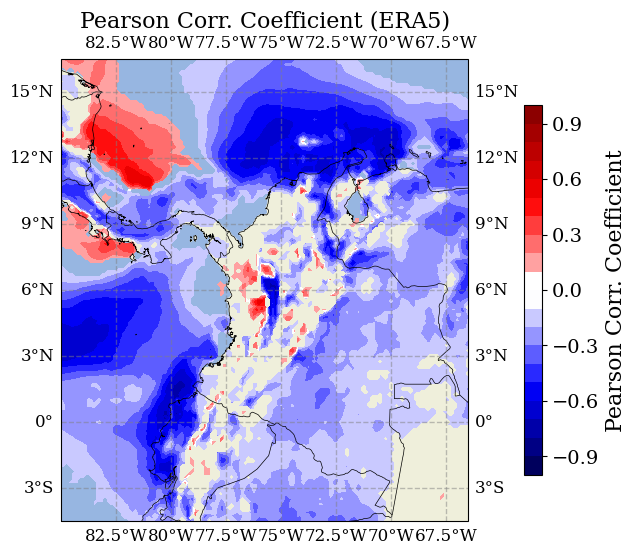

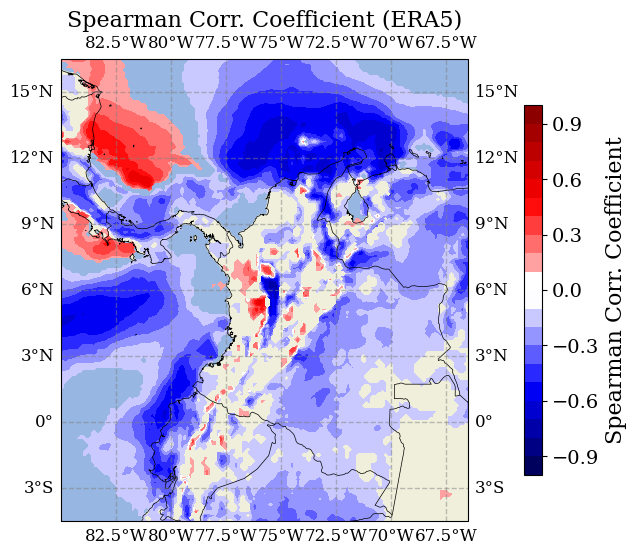

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LongitudeFormatter

# from cartopy.mpl.gridliner import LongitudeFormatter

def grafica_mapas_anom(inp, name, label_bar, lat, lon, lon_min, lon_max, lat_min, lat_max, bounds_levels, cmapp, dataset, date_start, date_end, Type, file_era=None):
    if dataset == 'CCMP': # se define resolucion espacial dependiendo de si es ERA5 o CCMP. esto para que quede impreso en el nombre del archivo al guardarlo
        resol = str(25)
    if dataset == 'ERA5': # se define resolucion espacial dependiendo de si es ERA5 o CCMP. esto para que quede impreso en el nombre del archivo al guardarlo
        resol = str(125)

    plt.close('all')
    fig = plt.figure(figsize=(8, 6)) 
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines('10m', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.LAND)

    if (file_era == 'ERA5_WIND_COL_1987_2018_monthly.nc') or (file_era == 'ERA5_PPT_COL_1987_2017_monthly_col.nc'):
        lon2, lat2 = np.meshgrid(lon, lat)
    else:
        lon2, lat2 = np.meshgrid(lon-360, lat)

    cs = ax.contourf(lon2, lat2[::-1], inp, len(bounds_levels), norm=MidpointNormalize(midpoint=-0.05), cmap=cmapp, levels=bounds_levels)
    # Crear una instancia de gridliner para los ejes
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=1, color='gray', alpha=0.5, linestyle='--')

    # Utilizar la clase LongitudeFormatter para dar formato a los valores de longitud
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)
    
#     ax.set_xticks(np.arange(lon_min, lon_max+1, 3), crs=ccrs.PlateCarree())
#     ax.set_yticks(np.arange(lat_min, lat_max+1, 3), crs=ccrs.PlateCarree())
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     lat_formatter = LatitudeFormatter()
#     ax.xaxis.set_major_formatter(lon_formatter)
#     ax.yaxis.set_major_formatter(lat_formatter)

    cbar = fig.colorbar(cs, ax=ax, extend='both', shrink=0.8, location='right', pad=0.09)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(label_bar, fontsize=16)

    plt.title(label_bar + ' (' + dataset + ')', fontsize=16)
    plt.show()
    plt.close('all')
    
#     plt.savefig(ruta_figuras+'ERA5/MAPA_CORR_WND-PPT/CON_PVALUE/Colombia/RAC/(CICLOANUALREMOVIDO)_'+name+'_'+dataset+'_'+str(date_start)+'_'+str(date_end)+'_'+resol+'_'+Type+".png", bbox_inches='tight', dpi=600)

# Se ejecuta la función de graficación 
# 'correlacion entre viento y ppt'
grafica_mapas_anom(spt_corr_E2_p, u'Corr_pearson_precip-windspeed_(Colombia)_pval5','Pearson Corr. Coefficient' ,lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','spd','ERA5_WIND_COL_1987_2018_monthly.nc')
grafica_mapas_anom(spt_corr_E2_s, u'Corr_spearma_precip-windspeed_(Colombia)_pval5','Spearman Corr. Coefficient',lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','spd','ERA5_WIND_COL_1987_2018_monthly.nc')


### USANDO BASEMAP >>> MAPA DE CORRELACION PPT CON VIENTOS TODA COLOMBIA (SOLO ERA5)

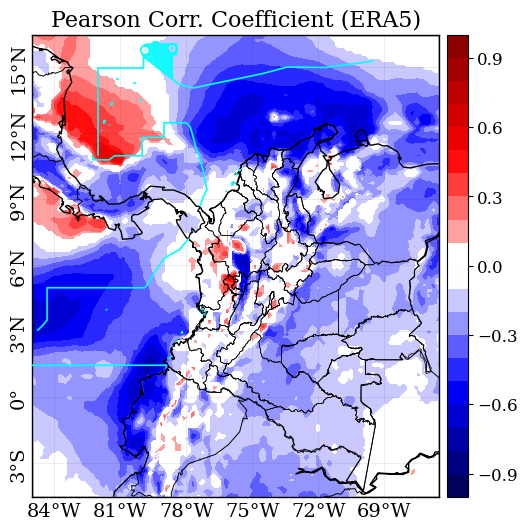

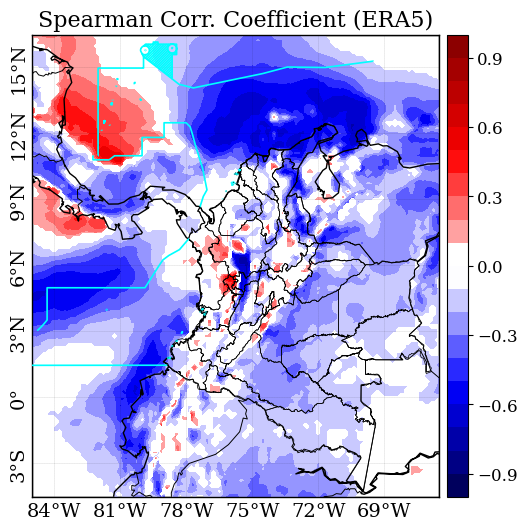

In [39]:
# MAPA DE CORRELACION PPT CON VIENTOS TODA COLOMBIA (SOLO ERA5)
#'para serie de 1987-2017 porque ese archivo requiere este cambio: lon2,lat2= np.meshgrid(lon,lat) abajo: '
def grafica_mapas_anom(inp,name,label_bar,lat,lon,lon_min,lon_max,lat_min,lat_max,bounds_levels,cmapp,dataset,date_start,date_end,Type,file_era=None):
    if dataset == 'CCMP': # se define resolucion espacial dependiendo de si es ERA5 o CCMP. esto para que quede impreso en el nombre del archivo al guardarlo
        resol = str(25)
    if dataset == 'ERA5': # se define resolucion espacial dependiendo de si es ERA5 o CCMP. esto para que quede impreso en el nombre del archivo al guardarlo
        resol = str(125)
    plt. close('all')
    fig=plt.figure(figsize=(8,6)) 
    ax=fig.add_subplot(1,1,1)
#     m = es el mapa base delimitado por: llcrnrlat = lower left corner latitude (latitud ubicada en la parte inferior izquierda del recuadro del mapa); urcrnrlat = upper right corner latitud (latitud ubicada en la parte superior derecha del recuadro; llcrnrlon = lower left corner longitud (longitud ubicada en la parte inferior del recuadro); urcrnrlon = upper right corner lon (longitud ubicada en la parte superior del recuadro)
    m         = Basemap(llcrnrlat=np.min(lat_min),urcrnrlat=np.max(lat_max), llcrnrlon=np.min(lon_min),urcrnrlon=np.max(lon_max), rsphere=6371200.,resolution='l',area_thresh=10000)
    if (file_era == 'ERA5_WIND_COL_1987_2018_monthly.nc') or (file_era == 'ERA5_PPT_COL_1987_2017_monthly_col.nc'):
        lon2,lat2= np.meshgrid(lon,lat) # np.meshgrid crea dos arrays bidimensionales, una de latitudes y otra de longitudes. Estas son las bases espaciales del mapa base
    else:
        lon2,lat2= np.meshgrid(lon-360,lat) # dependiendo de las longitudes se usa restando -360 o no
    x,y=m(lon2, lat2) # se incorpora al mapa base la grilla de longitudes y latitudes de los datos
    y           =  np.flipud(y) # se voletea en el eje y o latitudinal para evitar plotear el mapa al reves en y
    # se define el contorno o relleno del mapa, los parametros de barra de colores, niveles de las barras tipo de color, centralizado de la barra de colores en blanco etc
    cs = m.contourf(x,y,inp,len(bounds),norm= MidpointNormalize(midpoint=-0.05), cmap=cmapp,levels=bounds_levels) #lineas de contorno llenas, cmap= con el nombre de los colores
    # se leen los shapes de limites maritimos y departamentales
    m.readshapefile(ruta_shapes + 'shape_Limites_maritimos/f', 'f', linewidth=1.2, color = 'cyan',zorder=8)
    m.readshapefile(ruta_shapes + 'Departamentos/Servicios_Públicos__Departamentos','Departamentos',        linewidth=0.5, color = 'k')
    # se dibujan los paralelos
    parallels = m.drawparallels(np.arange(-90.,90,3.), labels=[1,0,0,0],linewidth=0.1,fontsize=14)
    # se dibujan los meridianos
    m.drawmeridians(np.arange(0, 360, 3.),labels=[0,1,0,1], linewidth=0.1,fontsize=14)
    # lineas costeras
    m.drawcoastlines()
    # limites politicos
    m.drawmapboundary()
    m.drawcountries(linewidth=0.7)
    # se crea la barra de colores
    m.colorbar()
    # se crea el titulo de la figura
    plt.title(label_bar +' ('+ dataset+')', fontsize=16)    
    # se rotan las etiquetas de los paralelos 90° para que ocupen menos espacio en la figura
    for m in parallels:
        try:
            parallels[m][1][0].set_rotation(90)
        except:
            pass
#     plt.show() # muestra la figura sin guardarla
    # Guara la figura en la ruta especificada
    plt.savefig(ruta_figuras+'ERA5/MAPA_CORR_WND-PPT/CON_PVALUE/Colombia/RAC/(CICLOANUALREMOVIDO)_'+name+'_'+dataset+'_'+str(date_start)+'_'+str(date_end)+'_'+resol+'_'+Type+".png",bbox_inches='tight',dpi=600)   
    plt.show()
#Se ejecuta la función de graficación 
# 'correlacion entre viento y ppt'
grafica_mapas_anom(spt_corr_E2_p, u'Corr_pearson_precip-windspeed_(Colombia)_pval5','Pearson Corr. Coefficient' ,lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','spd','ERA5_WIND_COL_1987_2018_monthly.nc')
grafica_mapas_anom(spt_corr_E2_s, u'Corr_spearma_precip-windspeed_(Colombia)_pval5','Spearman Corr. Coefficient',lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','spd','ERA5_WIND_COL_1987_2018_monthly.nc')


# 2. Mapa de correlación ONI con vientos; ONI con precipitación (Toda Colombia)

Se grafican las correlaciones de vientos con el índice ONI,esto se da pixel por pixel del mapa y de manera independiente. Esto también se hace para los datos de precipitación. Cada píxel del mapa evidencia un valor de correlación con el índice ONI, indicando la relación que existe entre los vientos/precipitación con ENSO, o en otras palabras la relación que existe entre las anomalías de wnd o ppt positivas/negativas con las anomalías cálidas/frías de la SST del Pacifico Tropical. 

### Ajuste de parametros en barras de colores para mapas de correlación: ppt vs ONI; wnd vs ONI

In [40]:
bounds       = np.arange(-1,1+0.1,0.1)#para que la barra quede en cero se debe 5.25/0.25 =21 (limite/level) debe dar numero entero de levels para que quede en centrada en cero
bonus        = np.arange(-1,1+0.1,0.1)
newcmap      = center_white_anom2('seismic', len(bonus), bonus, 0.1)

### USANDO BASEMAP >>> MAPA DE CORRELACION PPT VS ONI; WND VS ONI

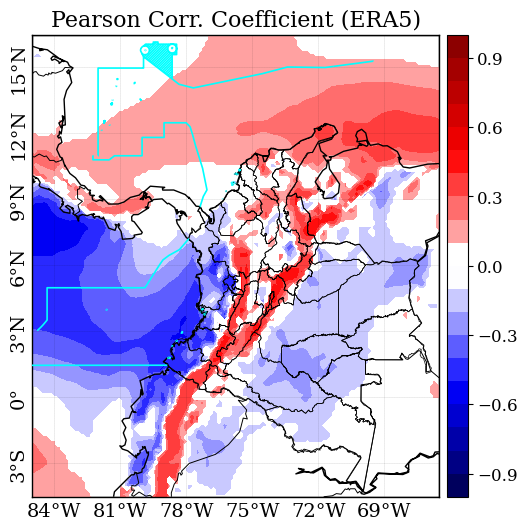

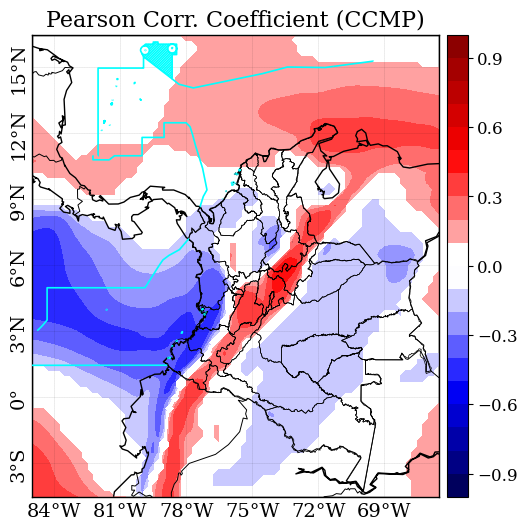

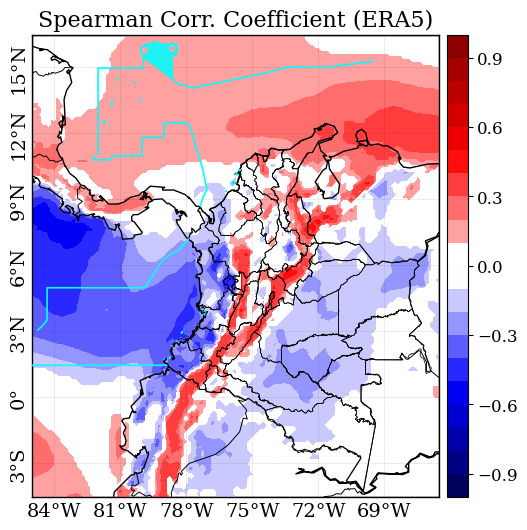

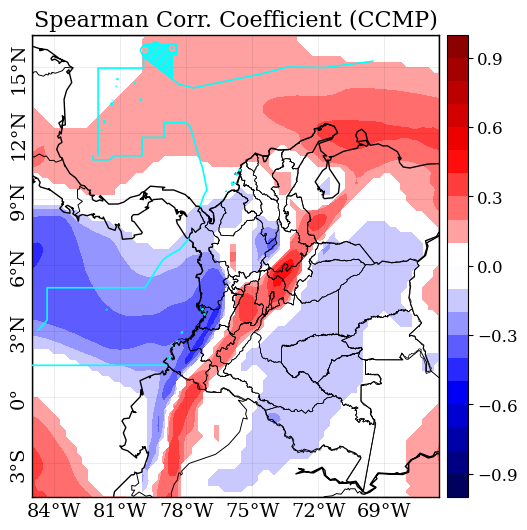

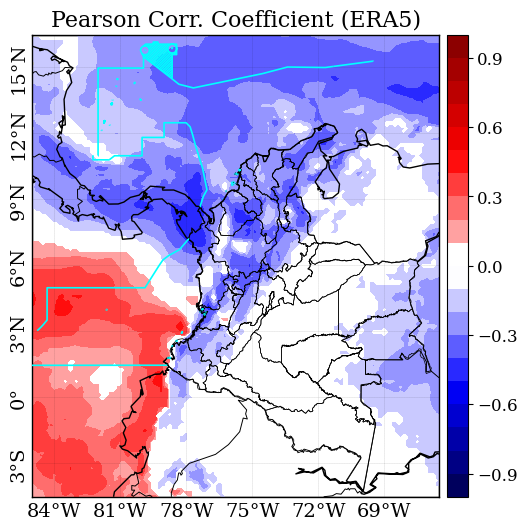

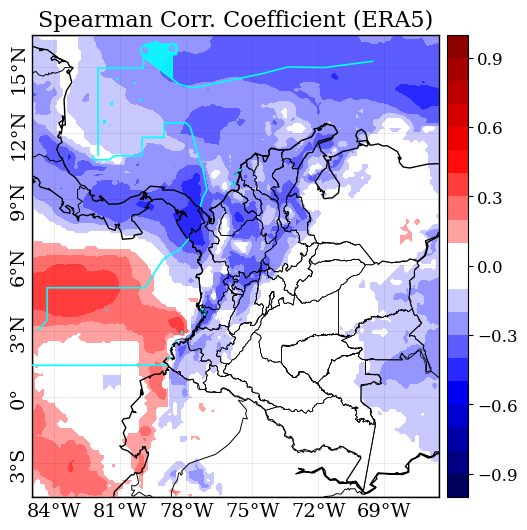

In [41]:
# 'para serie de 1987-2017 porque ese archivo requiere este cambio: lon2,lat2= np.meshgrid(lon,lat) abajo: '
def grafica_mapas_anom(inp,name,label_bar,lat,lon,lon_min,lon_max,lat_min,lat_max,bounds_levels,cmapp,dataset,date_start,date_end,Type,file_era=None):
    if dataset == 'CCMP':
        resol = str(25)
    if dataset == 'ERA5':
        resol = str(125)
    plt. close('all')
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)
    m         = Basemap(llcrnrlat=np.min(lat_min),urcrnrlat=np.max(lat_max), llcrnrlon=np.min(lon_min),urcrnrlon=np.max(lon_max), rsphere=6371200.,resolution='l',area_thresh=10000)
    if (file_era == 'ERA5_WIND_COL_1987_2018_monthly.nc') or (file_era == 'ERA5_PPT_COL_1987_2017_monthly_col.nc'):
        lon2,lat2= np.meshgrid(lon,lat)    
    else:
        lon2,lat2= np.meshgrid(lon-360,lat)
    x,y=m(lon2, lat2)
    y           =  np.flipud(y) 
    cs = m.contourf(x,y,inp,len(bounds),norm= MidpointNormalize(midpoint=-0.05), cmap=cmapp,levels=bounds_levels) #lineas de contorno llenas, cmap= con el nombre de los colores
    m.readshapefile(ruta_shapes + 'shape_Limites_maritimos/f', 'f', linewidth=1.2, color = 'cyan',zorder=8)
    m.readshapefile(ruta_shapes + 'Departamentos/Servicios_Públicos__Departamentos','Departamentos',linewidth=0.5, color = 'k')
    parallels = m.drawparallels(np.arange(-90.,90,3.), labels=[1,0,0,0],linewidth=0.1,fontsize=14)
    m.drawmeridians(np.arange(0, 360, 3.),labels=[0,1,0,1], linewidth=0.1,fontsize=14)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=0.7)
    m.colorbar()
    plt.title(label_bar +' ('+ dataset+')', fontsize=16)    
    for m in parallels:
        try:
            parallels[m][1][0].set_rotation(90)
        except:
            pass
#     plt.show()

    plt.savefig(ruta_figuras+'ERA5/MAPA_CORR_ONI/CON_PVALUE/Colombia/RAC/(CICLOANUALREMOVIDO)_'+name+'_'+dataset+'_'+str(date_start)+'_'+str(date_end)+'_'+resol+'_'+Type+".png",bbox_inches='tight',dpi=600)   
    plt.show()
# 'correlacion entre viento y oni'
grafica_mapas_anom(spd_corr_E2_p, u'Corr_pearson_ONI-windspeed_(Colombia)_pval5','Pearson Corr. Coefficient' ,lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','spd','ERA5_WIND_COL_1987_2018_monthly.nc')
grafica_mapas_anom(spd_corr_R2_p, u'Corr_pearson_ONI-windspeed_(Colombia)_pval5','Pearson Corr. Coefficient' ,lat_R2,lon_R2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'CCMP','1987-07','2017-12','spd')
grafica_mapas_anom(spd_corr_E2_s, u'Corr_spearma_ONI-windspeed_(Colombia)_pval5','Spearman Corr. Coefficient',lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','spd','ERA5_WIND_COL_1987_2018_monthly.nc')
grafica_mapas_anom(spd_corr_R2_s, u'Corr_spearma_ONI-windspeed_(Colombia)_pval5','Spearman Corr. Coefficient',lat_R2,lon_R2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'CCMP','1987-07','2017-12','spd')
# 'correlacion entre ppt y oni'
grafica_mapas_anom(ppt_corr_E2_p,u'Corr_pearson_ONI-Daily_total_precip_(Colombia)_pval5','Pearson Corr. Coefficient' ,lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','ppt','ERA5_PPT_COL_1987_2017_monthly_col.nc')
grafica_mapas_anom(ppt_corr_E2_s,u'Corr_spearma_ONI-Daily_total_precip_(Colombia)_pval5','Spearman Corr. Coefficient',lat_E2,lon_E2,-85.,-66.5,-4.5,16.5, bounds,newcmap,'ERA5','1987-07','2017-12','ppt','ERA5_PPT_COL_1987_2017_monthly_col.nc')


# 3. Mapa de correlación ONI con vientos (solo Caribe)

Se grafican las correlaciones al igual que en el Mapa base correlaciones wnd vs ONI, basados en los datos de CCMP y ERA5, pero únicamente consideran el Mar Caribe colombiano

### Ajuste de parametros en barras de colores para mapas de correlación ONI con vientos

Definición de cmap en terminos de center_white_anom2

In [42]:
# 'anomalias para velocidad anual Caribe'
bounds_car       = np.arange(-1,1+0.1,0.1)#para que la barra quede en cero se debe 5.25/0.25 =21 (limite/level) debe dar numero entero de levels para que quede en centrada en cero
bonus_car        = np.arange(-1,1+0.1,0.1)
newcmap_car      = center_white_anom2('seismic', len(bonus_car), bonus_car, 0.1)

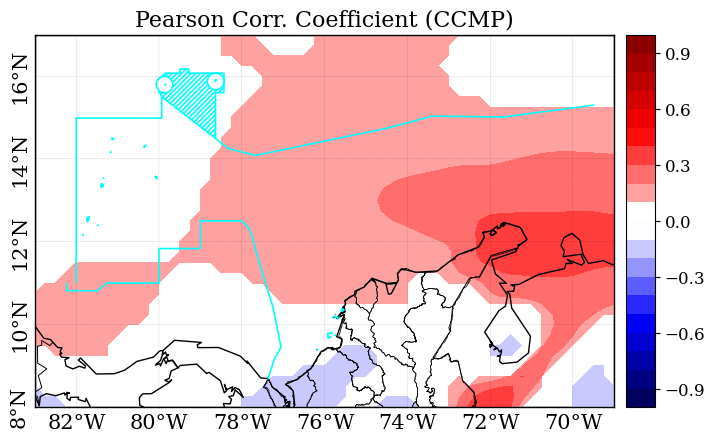

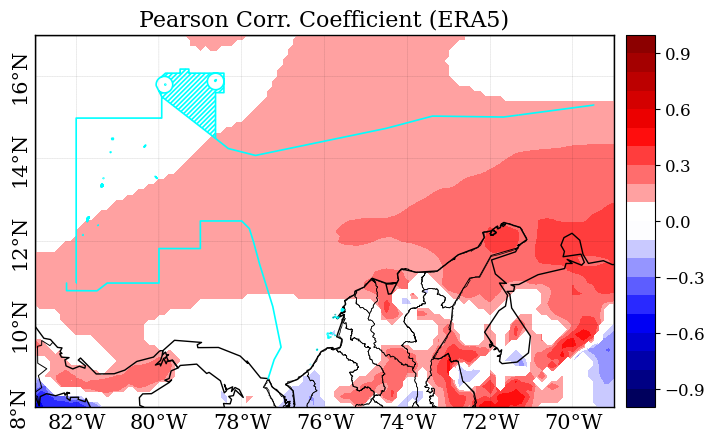

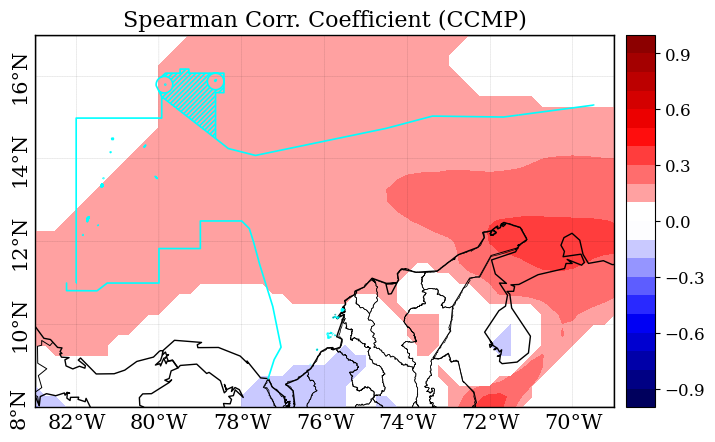

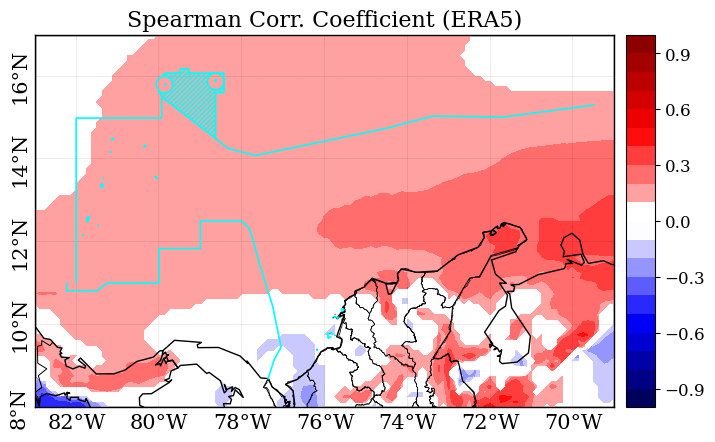

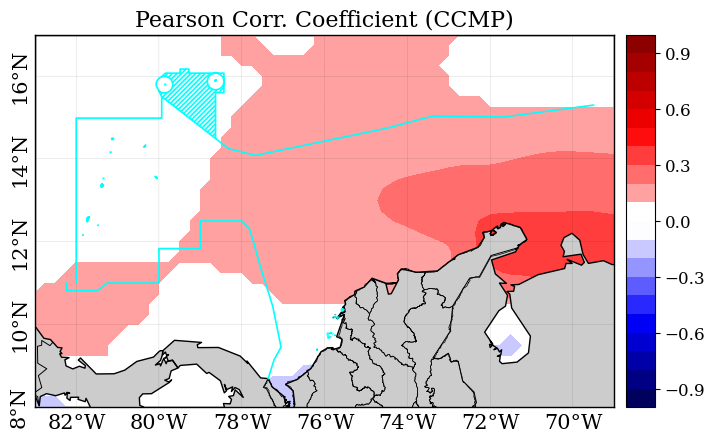

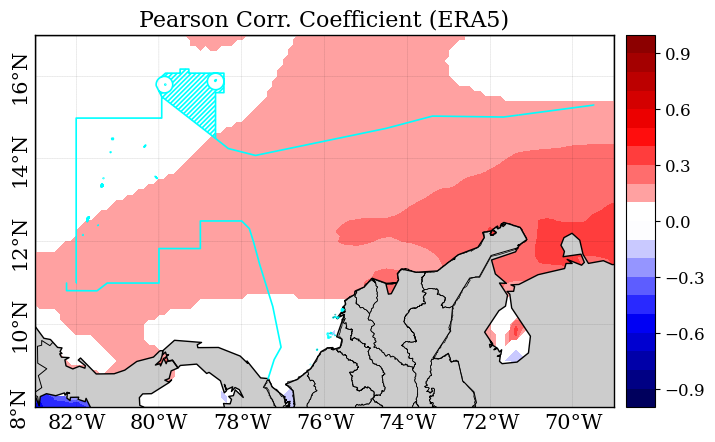

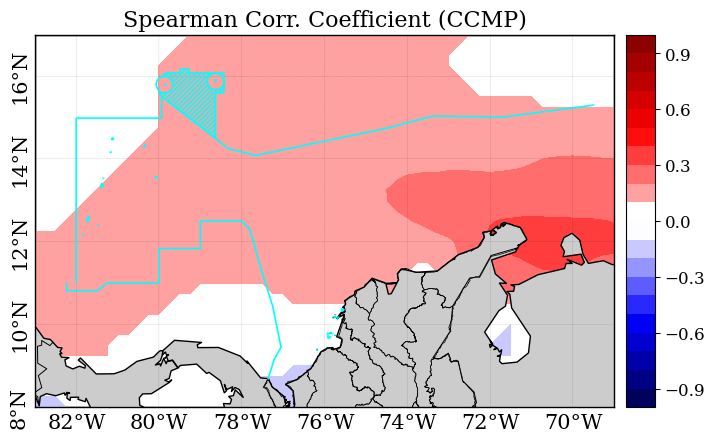

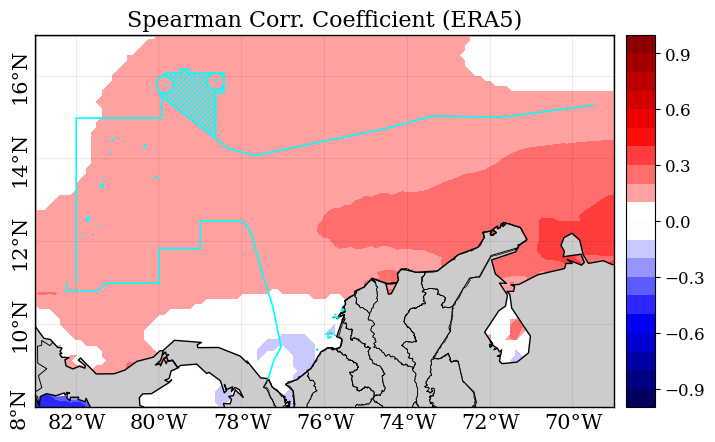

In [43]:
# MAPA DE CORRELACION ONI CON VIENTOS SOLO CARIBE( ERA Y CCMP) 

def grafica_mapas_anom(inp,name,label_bar,lat,lon,lon_min,lon_max,lat_min,lat_max,bounds_levels,cmapp,dataset,masked_conts,date_start,date_end,file_era=None):
    fig=plt.figure(figsize=(8,6))
    ax=fig.add_subplot(1,1,1)
    if dataset == 'CCMP':
        resol = str(25)
    if dataset == 'ERA5':
        resol = str(125)    
    m         = Basemap(llcrnrlat=np.min(lat_min),urcrnrlat=np.max(lat_max), llcrnrlon=np.min(lon_min),urcrnrlon=np.max(lon_max), rsphere=6371200.,resolution='l',area_thresh=10000)
    if file_era == 'ERA5_WIND_COL_1987_2018_monthly.nc':
        lon2,lat2= np.meshgrid(lon,lat)    
    else:
        lon2,lat2= np.meshgrid(lon-360,lat)
    x,y=m(lon2, lat2)
    y           =  np.flipud(y)  
    cs = m.contourf(x,y,inp,len(bounds_levels),norm= MidpointNormalize(midpoint=-0.05), cmap=cmapp,levels=bounds_levels) #lineas de contorno llenas, cmap= con el nombre de los colores
    if masked_conts == 'mask':
        m.fillcontinents()
    m.readshapefile(ruta_shapes + 'shape_Limites_maritimos/f', 'f', linewidth=1.2, color = 'cyan',zorder=8)
    m.readshapefile(ruta_shapes + 'Departamentos/Servicios_Públicos__Departamentos','Departamentos',        linewidth=0.5, color = 'k')
    parallels = m.drawparallels(np.arange(-90.,90,2.), labels=[1,0,0,0],linewidth=0.1,fontsize=15)
    m.drawmeridians(np.arange(0, 360, 2.),labels=[0,1,0,1], linewidth=0.1,fontsize=15)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=0.7)
    m.colorbar()
    plt.title(label_bar +' ('+ dataset+')', fontsize=16)
    for m in parallels:
        try:
            parallels[m][1][0].set_rotation(90)
        except:
            pass    
    plt.savefig(ruta_figuras+'ERA5/MAPA_CORR_ONI/CON_PVALUE/Caribe/RAC/(CICLOANUALREMOVIDO)_'+name+'_'+dataset+'_'+masked_conts+'_'+str(date_start)+'_'+str(date_end)+'_'+resol+".png",bbox_inches='tight',dpi=600)
    plt.show()

'sin mascara'
grafica_mapas_anom(spd_corr_R2_p,u'Corr_pearson_ONI-windspeed_(Caribe)_pval5','Pearson Corr. Coefficient',lat_R2,lon_R2,-83,-69,8,17 , bounds_car,newcmap_car,'CCMP','no_mask','1987-07','2017-12')
grafica_mapas_anom(spd_corr_E2_p,u'Corr_pearson_ONI-windspeed_(Caribe)_pval5','Pearson Corr. Coefficient',lat_E2,lon_E2,-83,-69,8,17 , bounds_car,newcmap_car,'ERA5','no_mask','1987-07','2017-12','ERA5_WIND_COL_1987_2018_monthly.nc')

grafica_mapas_anom(spd_corr_R2_s,u'Corr_spearma_ONI-windspeed_(Caribe)_pval5','Spearman Corr. Coefficient',lat_R2,lon_R2,-83,-69,8,17, bounds_car,newcmap_car,'CCMP','no_mask','1987-07','2017-12')
grafica_mapas_anom(spd_corr_E2_s,u'Corr_spearma_ONI-windspeed_(Caribe)_pval5','Spearman Corr. Coefficient',lat_E2,lon_E2,-83,-69,8,17, bounds_car,newcmap_car,'ERA5','no_mask','1987-07','2017-12','ERA5_WIND_COL_1987_2018_monthly.nc')
'lo anterior con mascara'
grafica_mapas_anom(spd_corr_R2_p,u'Corr_pearson_ONI-windspeed_(Caribe)_pval5','Pearson Corr. Coefficient',lat_R2,lon_R2,-83,-69,8,17 , bounds_car,newcmap_car,'CCMP','mask'   ,'1987-07','2017-12')
grafica_mapas_anom(spd_corr_E2_p,u'Corr_pearson_ONI-windspeed_(Caribe)_pval5','Pearson Corr. Coefficient',lat_E2,lon_E2,-83,-69,8,17 , bounds_car,newcmap_car,'ERA5','mask'   ,'1987-07','2017-12','ERA5_WIND_COL_1987_2018_monthly.nc')

grafica_mapas_anom(spd_corr_R2_s,u'Corr_spearma_ONI-windspeed_(Caribe)_pval5','Spearman Corr. Coefficient',lat_R2,lon_R2,-83,-69,8,17, bounds_car,newcmap_car,'CCMP','mask'   ,'1987-07','2017-12')
grafica_mapas_anom(spd_corr_E2_s,u'Corr_spearma_ONI-windspeed_(Caribe)_pval5','Spearman Corr. Coefficient',lat_E2,lon_E2,-83,-69,8,17, bounds_car,newcmap_car,'ERA5','mask'   ,'1987-07','2017-12','ERA5_WIND_COL_1987_2018_monthly.nc')

###  DECONSTRUCCIÓN FUNCIÓN ANOMALIAS_DATAFRAME

In [64]:
#deconstrucción funcion ANOMALIAS_DATAFRAME
df_VAR = df_spd_rh_E2['1987-07': '2017-12']
# "estandariza dataframe reshepeados provenientes de netcdf"
# def ANOMALIAS_DATAFRAME(df_VAR): # df_VAR es un dataframe de los datos de vientos o precipitación
ANOMA = df_VAR * np.nan # crea un dataframe de iguales dimensiones que df_VAR pero lleno de NaNs
STDAR = df_VAR * np.nan # crea un dataframe de iguales dimensiones que df_VAR pero lleno de NaNs
for i in np.arange(1,13): # itera en los 12 meses del año (llega hasta i = 12, no toma el 13)
    mes = df_VAR.loc[df_VAR.index.month==i] # df.loc es una función de pandas que ubica los datos segun el criterio. En este caso el criterio es los datos del iésimo mes.  Ejemplo si el i = 1 (enero), entonces la variable 'mes' será un dataframe que contenga todos los eneros de todos los años en el mapa
    media = mes.mean() # Tipo de dato pandas Series. Es el Promedio del mes i, una serie de pandas y la longitud de la serie es igual al numero de pixeles en el mapa
    std = mes.std()    # Tipo de dato pandas Series. Es la Desviación estandar del mes i, es una serie de pandas y la longitud de la serie es igual al numero de pixeles en el mapa
    anoma = mes - media # Tipo de dato pandas DataFrame.  anoma es un dataframe que contiene todos los eneros, pero cada dato de cada hora (si son horarios los datos) se le ha restado la media de la serie de los eneros y asi sucesivamente febreros, marzos con cada iteración
    ANOMA[ANOMA.index.month==i] = anoma # Se sobreescriben los NaNs en el dataframe creado previamente 'ANOMA'. En este se ponen todos los eneros, pero en terminos de sus anomalias y asi sucesivamente en cada iteración se van llenando los meses del año, las veces que esten en el Df por ejemplo desde 1987 hasta la actualidad, hay muchos eneros que se ponen
    STDAR[STDAR.index.month==i] = anoma/std # De igual manera que con ANOMA, Se sobreescriben los NaNs en el dataframe creado previamente 'STDAR'. Pero esta vez con anomalias estandarizadas
# return ANOMA, STDAR

In [70]:
# #deconstrucción funcion ANOMALIAS_DATAFRAME
# print(i)  # último mes que itero el for
# print(mes)# último mes seleccionado por df_VAR.loc[] en el for

In [65]:
# #deconstrucción funcion ANOMALIAS_DATAFRAME
# print(media) # media de los diciembres; se tienen 27080 pixeles promediados correspondientes a la media de los diemebres

In [66]:
# #deconstrucción funcion ANOMALIAS_DATAFRAME
# print(std) #  desviación estandar de los diciembres

In [67]:
# #deconstrucción funcion ANOMALIAS_DATAFRAME
# print(anoma) # anomalias de los diciembres

In [68]:
# #deconstrucción funcion ANOMALIAS_DATAFRAME
# print(ANOMA) # anomalias de todos los datos

In [69]:
# #deconstrucción funcion ANOMALIAS_DATAFRAME
# print(STDAR) # anomalias estandarizadas de todos los datos